# Lab 10 - Pytorch

- **Author:** Suraj R. Nair, Satej Soman
- **Date:** April 9, 2025
- **Course:** INFO 251: Applied Machine Learning

## Topics
1. Loading pre-trained models
2. Saving / loading model weights
3. Examine and interpret model summaries
4. Visualize feature maps

References
- [Google Deep Learning Playbook](https://developers.google.com/machine-learning/guides/deep-learning-tuning-playbook)
- [Visualizing Feature Maps 1](https://medium.com/@miramnair/feature-maps-lets-visualize-them-729a98faac30), [Visualizing Feature Maps 2](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)
- CS231n, Stanford [course notes](https://cs231n.github.io/convolutional-networks/#layerpat)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import matplotlib.pyplot as plt
import numpy as np

<ipython-input-1-e85e9d53a0a6>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


1. Load a pretrained ResNet

In [2]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet 50 model
    self.model = models.resnet50(pretrained=True)

    # Change input to take Grayscale image, instead of RGB images.

    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Change the output layer to output 10 classes instead of 1000 classes
    num_features = self.model.fc.in_features
    self.model.fc = nn.Linear(num_features, 10)

  def forward(self, x):
    return self.model(x)


my_resnet = MnistResNet()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


2. Generate a random image of size 244 X 244, and confirm that the new model works

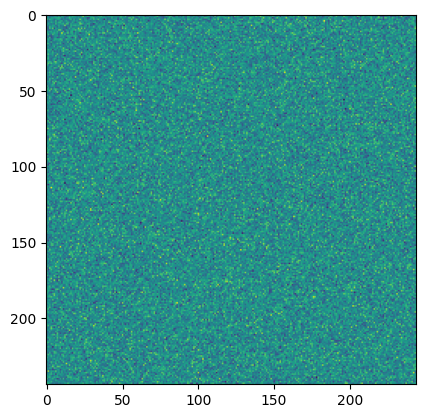

In [4]:
input = torch.randn((16,1,244,244))
# output = my_resnet(input)

plt.imshow(input[0][0])

# print(output.shape)



In [5]:
output = my_resnet(input)

In [7]:
output.shape

torch.Size([16, 10])

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

3. Save / load weights

In [9]:
torch.save(my_resnet.state_dict(), 'mnist_classifier.pth')

model2 =  MnistResNet().to(device)
model2.load_state_dict(torch.load('mnist_classifier.pth'))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

4. Load a pretrained model, examine model summary, visualize feature maps

Notes:
- output size for a convolutional layer (W - F + 2P) / S + 1
  - W: input size
  - F: filter size
  - P: padding
  - S: stride

- number of parameters in a layer: (F X F X C_in) X C_out + C_out_bias:
  - F: filter size
  - C_in: number of input channels
  - C_out: number of output channels
  - C_out_bias: bias (if true)


In [10]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [18]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [13]:
%pip install torchinfo
from torchinfo import summary

In [14]:
summary(model, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [16, 64, 56, 56]          --
│

In [17]:
#first input layer
print((224 - 7 + 6)/2 + 1)

# parameters in first convolutional layer:
print((7 * 7 * 3) * 64)

# parameters in first conv layer in basic block1:
print((3*3*64) * 64)

112.5
9408
36864


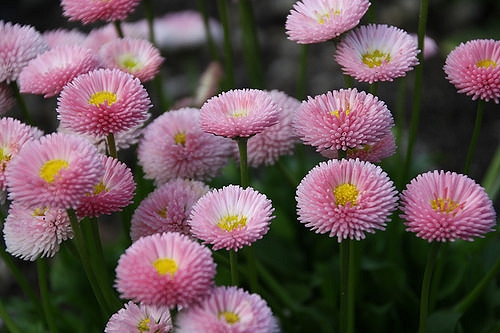

In [20]:
## get a an image for testing
from PIL import Image
import requests
url = 'https://s3.amazonaws.com/eit-planttoolbox-prod/media/images/Bellis_Perennis--Morgaine--CC_BY_2.0.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [21]:


## Store convolutional layer weights
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Number of convolution layers: {counter}")

## transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Pre-process image
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

## store and save the outputs from each layer
outputs = []
names = []
for layer in conv_layers:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))


processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())





Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
17


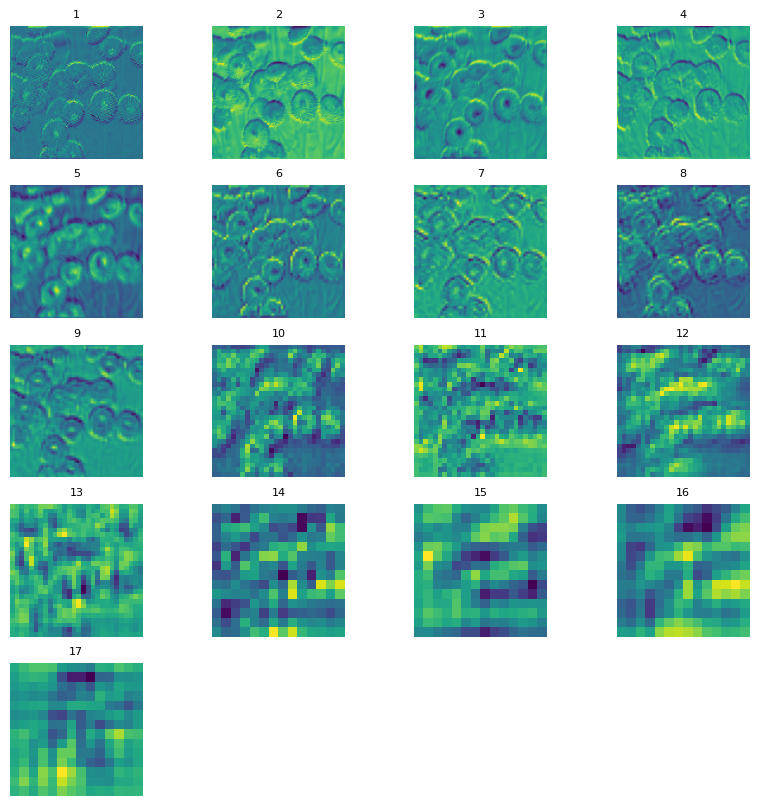

In [22]:
## Plot the feature maps
fig = plt.figure(figsize=(10, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(i+1, fontsize=8)

plt.show()